<a href="https://colab.research.google.com/github/KobDias/RedesNeurais/blob/main/RedeNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rede neural!

Vamos começar importando!

In [ ]:
import numpy as np
import torch #pytorch importado para juntar no tensorflor
import torch.nn.functional as F # funções pras redes Neurais
import torchvision # visão computacional no pytorch
import matplotlib.pyplot as plt # tabelas
from time import time #peggar tempo
from torchvision import datasets, transforms
from torch import nn,optim

Vamos então baixar o dataset do MNIST e transforma isso em tensor pra ter melhor performance com o tensorFlow

In [ ]:
transform = transforms.ToTensor() #Imagem to tensor
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform) # carrega o treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #Cria um buffer que pega os dados por partes

valset = datasets.MNIST('../MNIST_data/', download=True, train=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 127MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 25.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 100MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.92MB/s]


Conferir se as imagens estão certas:

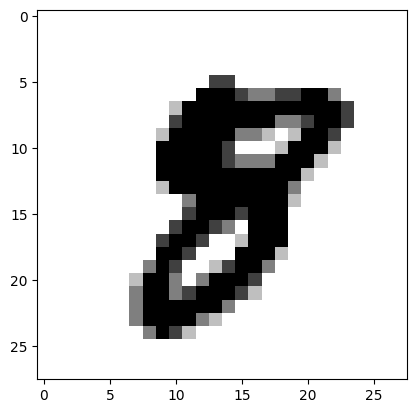

In [ ]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

Verificando o tamanho do Tensor da imagem.

In [ ]:
print(imagens[0].shape) # verificar dimensões de cada iamgem
print(etiquetas[0].shape) # Verificar o tamanho de cada etuqueta

torch.Size([1, 28, 28])
torch.Size([])


Então, bora pegar uma aplicação Keras com as redes neurais que queremos aqui: https://keras.io/api/applications/

Vou usar InceptionV3

Vamos inserir as camadas da rede:

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada. 784neuronios conectados a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1. 128 neuronios, ligados a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neuronios ligados a 10

        #Não há necessidadede definir camada de saida, pois so precisamos pegar o output da camada interna 2
    def forward(self,X):
        X = F.relu(self.linear1(X)) # camada de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # camada de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # camada de saída
        return F.log_softmax(X, dim=1) # dados usados para calcular a perda

In [ ]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define o otimizador
  inicio = time() # saber o tempo do treino

  criterio = nn.NLLLoss() # definindo criterio para calcular perda
  EPOCHS = 10 # numero de epocas que o algoritmo roda. Um bom treinamento tem 100!
  modelo.train() #ativando o modo treino

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # zerando a perda acumulada

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) # transformando a imagem em vetor de 28*28 casas
      otimizador.zero_grad() # zerando os gradientes

      output = modelo(imagens.to(device)) # passando as imagens no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda na epoca

      perda_instantanea.backward() # fazendo a back propagation a partir da perda

      otimizador.step() # atualizando os pesos e a bias

      perda_acumulada += perda_instantanea.item() # atualizando a perda acumulada
  else:
    print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ", (time()-inicio)/60)

In [ ]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativar o autograd para acelerar a validação. Grafos computacionais tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) #output do modelo em escala logaritma

      ps = torch.exp(logps) # converte output para escala normal(tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) #converte o tensor em numero que o modelo reviu
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

Vamos rodar o modelo! Vamos verificar se tem o CUDA no pc

In [ ]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)